In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys, json, pickle, itertools, numpy as np, pandas as pd, scipy.sparse as sp
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import roc_auc_score
import networkx as nx

import torch, torch.nn as nn, torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

import dgl, dgl.nn.pytorch.conv as conv

import phate, umap

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

2023-02-28 14:58:25.617958: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-28 14:58:26.156072: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-28 14:58:26.156152: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-28 14:58:26.156157: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [3]:
df = pd.read_pickle(os.path.expanduser('../data/sergio_bifurcation_df.pkl'))
df_phate = pd.read_pickle(os.path.expanduser('../data/sergio_bifurcation_df_phate.pkl'))

100

In [55]:
from MIOFlow.utils import generate_steps, set_seeds, config_criterion
from MIOFlow.models import make_model, Autoencoder
from MIOFlow.plots import plot_comparision, plot_losses
from MIOFlow.train import train_ae, training_regimen
from MIOFlow.constants import ROOT_DIR, DATA_DIR, NTBK_DIR, IMGS_DIR, RES_DIR
from MIOFlow.datasets import (
    make_diamonds, make_swiss_roll, make_tree, make_eb_data, 
    make_dyngen_data
)
from MIOFlow.geo import setup_distance
from MIOFlow.exp import setup_exp
from MIOFlow.eval import generate_plot_data

import os, pandas as pd, numpy as np, \
    seaborn as sns, matplotlib as mpl, matplotlib.pyplot as plt, \
    torch, torch.nn as nn

from tqdm.notebook import tqdm
import time

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [9]:
use_cuda = torch.cuda.is_available()
use_cuda

True

In [29]:
dff = df.copy()
df.loc[:, 'samples'] = df.pseudotime

In [33]:
df = df.drop(columns='pseudotime cell_types'.split())

In [36]:
model_features = df.columns.size-1
groups = sorted(df.samples.unique())
hold_one_out = False; hold_out='random'

In [37]:
# These determine the logic flow for training: 
#   use_emb=True use_gae=False is only the encoder to match the approximation of the geodesic.
#   use_emb=False use_gae=True the full Geodesic Autoencoder (GAE), i.e. matching the geodesic and a reconstruction loss.
#   use_emb=False use_gae=False Is not using the GAE.
#   use_emb=True use_gae=True, is redundant and should raise an error. 
use_emb = False
use_gae = True

need_to_train_gae = (use_emb or use_gae) and use_emb != use_gae

# If the reconstruction loss needs to be computed.
recon = use_gae and not use_emb 

# These are training GAE hyperparameters needed for training
# Distance_type in ['gaussian', 'alpha_decay'], and Gaussian scale
distance_type = 'phate'
rbf_length_scale=0.5
dist = setup_distance(distance_type, rbf_length_scale=rbf_length_scale)

#Can be changed depending on the dataset
n_epochs_emb = 1000
samples_size_emb = (30, )

# Layers for the Geodesic Autoencoder
gae_embedded_dim = 2
encoder_layers = [model_features, 8, gae_embedded_dim]

gae = Autoencoder(
    encoder_layers = encoder_layers,
    decoder_layers = encoder_layers[::-1],
    activation='ReLU', use_cuda = use_cuda
)
optimizer = torch.optim.AdamW(gae.parameters())

In [41]:
import warnings

In [43]:
# Added in extra cell just for iterative programming / running of code
#   but could be added to code block above
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    
    if need_to_train_gae:
        start_time_geo = time.time()

        losses = train_ae(
            gae, df, groups, optimizer, 
            n_epochs=n_epochs_emb, sample_size=samples_size_emb,
            noise_min_scale=0.09, noise_max_scale=0.15, 
            dist=dist, recon=recon, use_cuda=use_cuda,
            hold_one_out=hold_one_out, hold_out=hold_out, 
            sample_with_replacement=True
        )
        run_time_geo = time.time() - start_time_geo

        print(run_time_geo)
        autoencoder = gae
    else:
        autoencoder = None

  0%|          | 0/1000 [00:00<?, ?it/s]

Train loss recon: 0.63581
Train loss dist: 27175.02148
Train loss recon: 0.56239
Train loss dist: 19498.40234
Train loss recon: 0.42916
Train loss dist: 12869.95605
Train loss recon: 0.34738
Train loss dist: 13948.3252
Train loss recon: 0.30298
Train loss dist: 11779.35254
Train loss recon: 0.27839
Train loss dist: 12356.14746
Train loss recon: 0.25542
Train loss dist: 12776.97168
Train loss recon: 0.24844
Train loss dist: 12621.4209
Train loss recon: 0.23473
Train loss dist: 10285.53809
Train loss recon: 0.23024
Train loss dist: 12790.25
Train loss recon: 0.23004
Train loss dist: 11570.90527
Train loss recon: 0.22539
Train loss dist: 10869.00098
Train loss recon: 0.22709
Train loss dist: 10616.81641
Train loss recon: 0.21302
Train loss dist: 10746.02246
Train loss recon: 0.209
Train loss dist: 10358.41504
Train loss recon: 0.20015
Train loss dist: 7022.38672
Train loss recon: 0.19723
Train loss dist: 7595.18066
Train loss recon: 0.19361
Train loss dist: 7427.0083
Train loss recon: 0.1

In [44]:
set_seeds(10)

#Directory where results are saved
exp_name = 'test'

# density loss knn
use_density_loss = True

# Weight of density (not percentage of total loss)
lambda_density = 15

# For petal=LeakyReLU / dyngen=CELU
activation = 'CELU'

# Can change but we never really do, mostly depends on the dataset.
layers = [16,32,16]

# Scale of the noise in the trajectories. Either len(groups)*[float] or None. Should be None if using an adaptative ODE solver.
sde_scales = len(groups)*[0.2] 

if recon:    
    model_features = gae_embedded_dim

model = make_model(
    model_features, layers, 
    activation=activation, scales=sde_scales, use_cuda=use_cuda
)

In [57]:


# Basically "batch size"
sample_size=(60, )

# Training specification
n_local_epochs = 2
n_epochs = 2
n_post_local_epochs = 0

# Using the reverse trajectories to train
reverse_schema = False
# each reverse_n epoch
reverse_n = 2

criterion_name = 'ot'
criterion = config_criterion(criterion_name)

optimizer = torch.optim.AdamW(model.parameters())

# Bookkeeping variables
batch_losses = []
globe_losses = []
if hold_one_out and hold_out in groups:
    local_losses = {f'{t0}:{t1}':[] for (t0, t1) in generate_steps(groups) if hold_out not in [t0, t1]}
else:
    local_losses = {f'{t0}:{t1}':[] for (t0, t1) in generate_steps(groups)}

# For creating output.
n_points = 100
n_trajectories = 100
n_bins = 100

In [58]:
opts = {
    'use_cuda': use_cuda,
    'model_features': model_features,
    'exp_name': exp_name,
    'groups': groups,
    'sample_size': sample_size,
    'use_emb': use_emb,
    'n_local_epochs': n_local_epochs,
    'n_epochs': n_epochs,
    'n_post_local_epochs': n_post_local_epochs,
    'criterion_name': criterion_name,
    'hold_one_out': hold_one_out,
    'use_density_loss': use_density_loss,
    'n_points': n_points,
    'n_trajectories': n_trajectories,
    'n_bins': n_bins,
    'autoencoder': autoencoder,
    'activation_ode': activation,
    'layer': layers,
    'lambda_density':lambda_density,
    'use_gae': use_gae,
    'sde_scales': sde_scales,
    'hold_out':hold_out,
    'encoder_layers': encoder_layers,
    'n_epochs_emb': n_epochs_emb,
    'samples_size_emb': samples_size_emb,
    'recon': recon,
    'distance_type':distance_type,
    'rbf_length_scale':rbf_length_scale,
}

In [59]:
exp_dir, logger = setup_exp('./mioflow', opts, exp_name) 

In [60]:
exp_dir

'./mioflow/test'

In [63]:
start_time = time.time()
local_losses, batch_losses, globe_losses = training_regimen(
    # local, global, local train structure
    n_local_epochs=n_local_epochs, 
    n_epochs=n_epochs, 
    n_post_local_epochs=n_post_local_epochs,
    
    # where results are stored
    exp_dir=exp_dir, 

    # BEGIN: train params
    model=model, df=df, groups=groups, optimizer=optimizer, 
    criterion=criterion, use_cuda=use_cuda,
    
    hold_one_out=hold_one_out, hold_out=hold_out,
    
    use_density_loss=use_density_loss, 
    lambda_density=lambda_density,
    
    autoencoder=autoencoder, use_emb=use_emb, use_gae=use_gae, 
    
    
    sample_with_replacement=True,
    
    
    sample_size=sample_size, logger=logger,
    reverse_schema=reverse_schema, reverse_n=reverse_n,
    # END: train params
    
    plot_every=None,
    n_points=n_points, n_trajectories=n_trajectories, n_bins=n_bins, 
    #local_losses=local_losses, batch_losses=batch_losses, globe_losses=globe_losses
)
run_time = time.time() - start_time + run_time_geo if use_emb or use_gae else time.time() - start_time
logger.info(f'Total run time: {np.round(run_time, 5)}')

Pretraining Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

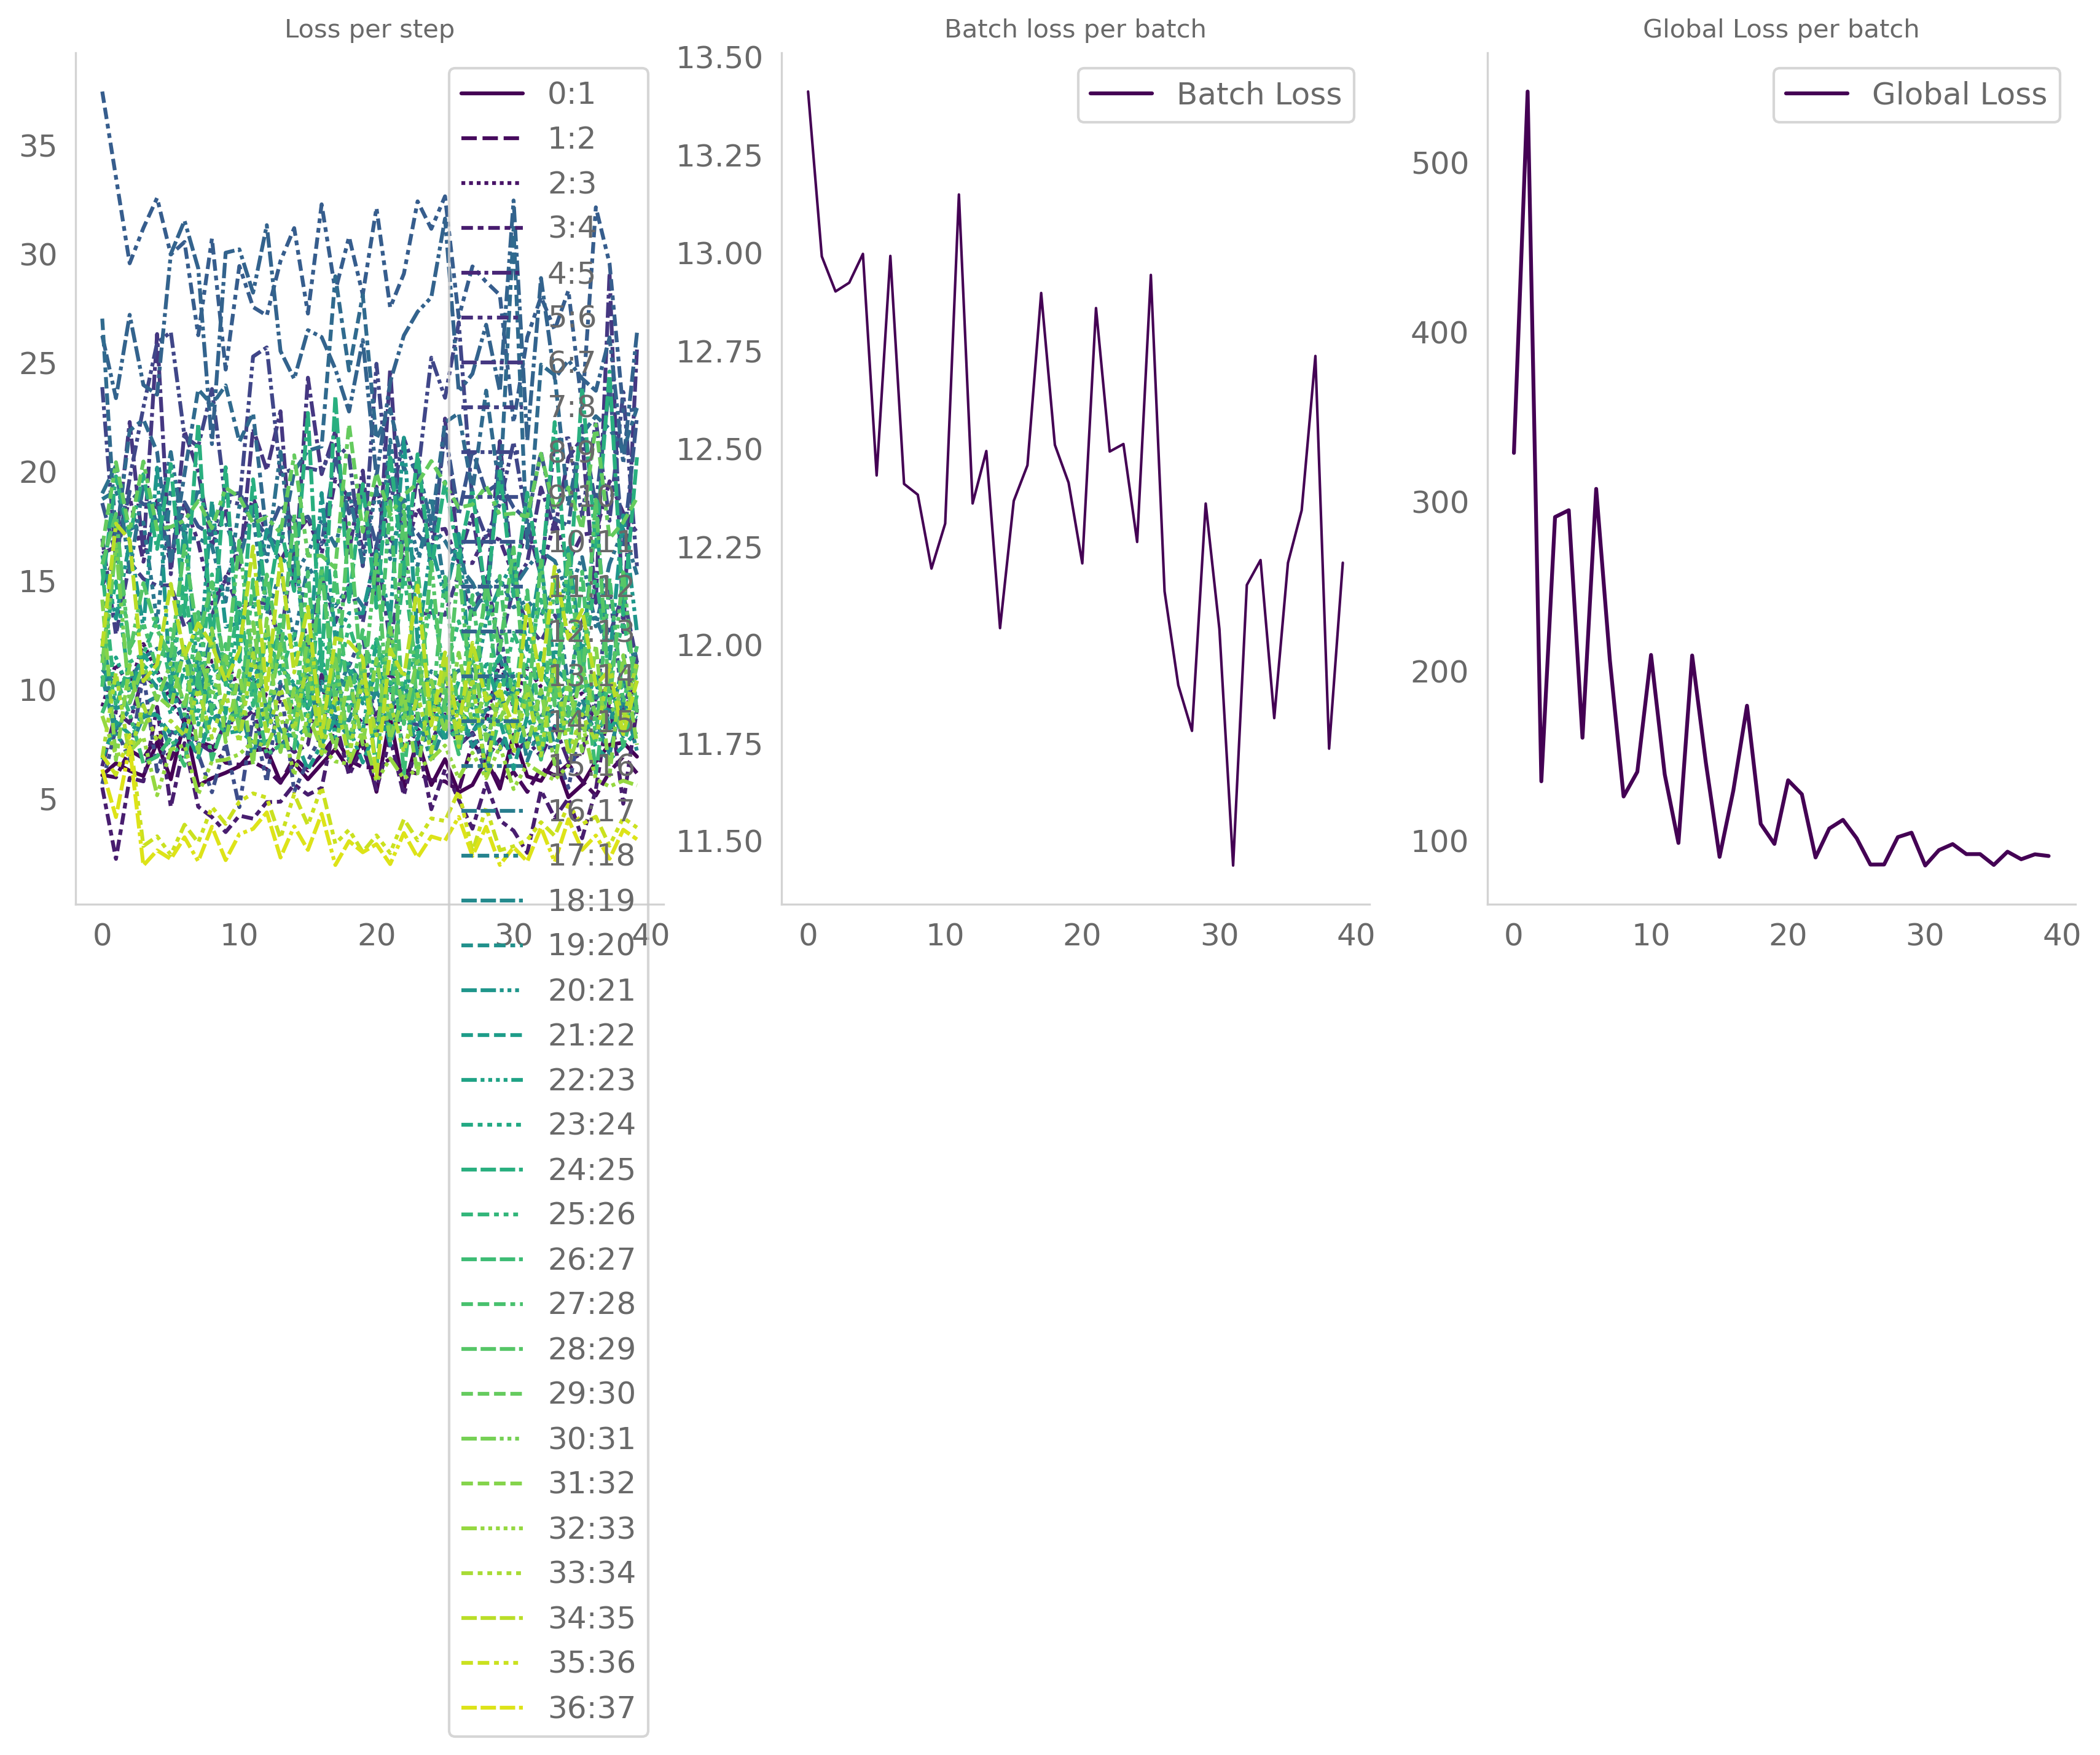

In [64]:
plot_losses(
    local_losses, batch_losses, globe_losses, 
    save=False, path=exp_dir, file='losses.png'
)

In [65]:
generated, trajectories = generate_plot_data(
    model, df, n_points, n_trajectories, n_bins, use_cuda=use_cuda, samples_key='samples', logger=logger,
    autoencoder=autoencoder, recon=recon
)

In [66]:
df

gene_0    gene_1    gene_2    gene_3    gene_4    gene_5  \
barcode                                                                 
cell_0    -1.250401 -0.718515  0.641716  0.962580 -1.098174 -0.623468   
cell_1    -1.187217 -1.212566  1.042232  1.539954 -1.261627 -0.541408   
cell_2    -1.056785  0.091934 -0.085670 -0.143176 -1.850067 -0.596117   
cell_3    -1.199164 -0.568225  0.668328  0.402067 -1.411729 -0.572103   
cell_4    -1.197591 -0.549304  0.243224  0.794857 -1.426090 -0.578485   
...             ...       ...       ...       ...       ...       ...   
cell_1195  1.604184 -0.033032 -0.676839 -0.539045  1.785073 -0.109201   
cell_1196  1.316304  0.261349 -1.126950 -0.773829  1.238433 -0.133165   
cell_1197  1.093555  0.719039 -0.800677 -0.836876  1.393457 -0.298273   
cell_1198 -0.064756 -0.834700  0.934661  0.480304 -0.010646 -0.469105   
cell_1199 -0.517723  0.004100  0.354133  0.550865  0.171735 -0.484653   

             gene_6    gene_7    gene_8    gene_9  ...   gene_91   gene_92  \
barcode                                            ...                       
cell_0    -1.297633 -1.154580 -1.247463 -1.622752  ...  1.117498  0.557696   
cell_1    -1.592961 -1.336582 -1.132725 -1.597903  ...  1.016378  1.492499   
cell_2    -1.446918 -1.434600 -1.136987 -1.644451  ...  1.778293  0.130932   
cell_3    -1.511033 -1.177812 -1.132422 -1.624660  ...  1.635906 -0.306457   
cell_4    -1.399564 -1.289466 -1.266619 -1.611652  ...  1.506022 -0.248014   
...             ...       ...       ...       ...  ...       ...       ...   
cell_1195  1.319846  1.133633  1.229611  0.941858  ... -0.787598 -0.302423   
cell_1196  1.259273  0.712440  0.615176  0.143752  ... -0.513064 -2.061063   
cell_1197  1.177625  1.082575  1.483409  0.844254  ... -0.705765  1.251031   
cell_1198  0.363748  0.018762 -0.130375  0.675364  ... -0.671628  1.383197   
cell_1199 -0.030983 -0.358203 -0.087447 -0.055551  ... -0.577623  1.020813   

            gene_93   gene_94   gene_95   gene_96   gene_97   gene_98  \
barcode                                                                 
cell_0     0.734422 -1.195440 -1.411656  1.594759  1.728632 -0.592243   
cell_1     1.689281 -2.163361 -0.531284  1.429807  1.332867 -0.619129   
cell_2     1.499580  0.959419  0.185496  1.132942  1.349235 -0.549998   
cell_3     1.492353 -0.291984 -0.193335  1.182831  1.451377 -0.588869   
cell_4     1.765936  0.475004 -0.232320  2.012317  1.781413 -0.603653   
...             ...       ...       ...       ...       ...       ...   
cell_1195 -0.763163 -0.830265  1.156137  0.171201 -0.659870  1.971051   
cell_1196 -0.223721 -0.395216  0.070219 -0.627168 -0.357413  2.445148   
cell_1197 -0.182150  0.828040 -1.148654 -0.609348 -1.285394  1.514566   
cell_1198 -0.705608  1.065501  0.704335 -1.005225 -0.363443  0.111775   
cell_1199 -0.350536 -0.028842  0.251158 -0.601302 -0.462032 -0.109594   

            gene_99  samples  
barcode                       
cell_0     1.650972        1  
cell_1     1.510389        0  
cell_2     1.575336        1  
cell_3     1.389014        1  
cell_4     1.484398        1  
...             ...      ...  
cell_1195 -0.641354       37  
cell_1196 -0.835408       37  
cell_1197 -0.671321       37  
cell_1198 -0.289890       29  
cell_1199 -0.624663       26  

[1200 rows x 101 columns]

In [74]:
generated.shape

(38, 100, 100)

In [75]:
trajectories.shape

(100, 100, 100)

In [90]:
latent_cells = autoencoder.encoder(torch.Tensor(df.drop(columns='samples').values).cuda())

In [91]:
latent_cells = latent_cells.detach().cpu().numpy()

In [92]:
latent_cells.shape

(1200, 2)

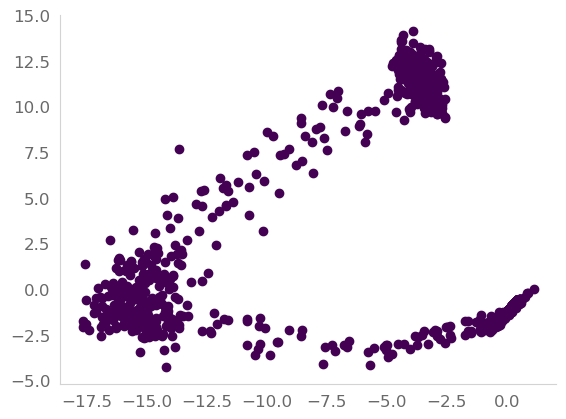

In [93]:
plt.scatter(latent_cells[:, 0], latent_cells[:, 1])

In [97]:
n_points

100

In [96]:
generated[0].shape

(100, 100)

In [98]:
df.drop(columns='samples').values.shape

(1200, 100)

In [101]:
#`(n_bins, n_points, len(df.columns) - 1)`
trajectories.shape
res = []
for _bin in trajectories:
    latent = autoencoder.encoder(torch.Tensor(_bin).cuda())
    latent = latent.detach().cpu().numpy()
    res.append(latent.tolist())
res = np.array(res)

for trajectory in np.transpose(res, axes=(1,0,2)):
    plt.plot(res[:, 0], res[:, 1], alpha=0.1, color='Black');

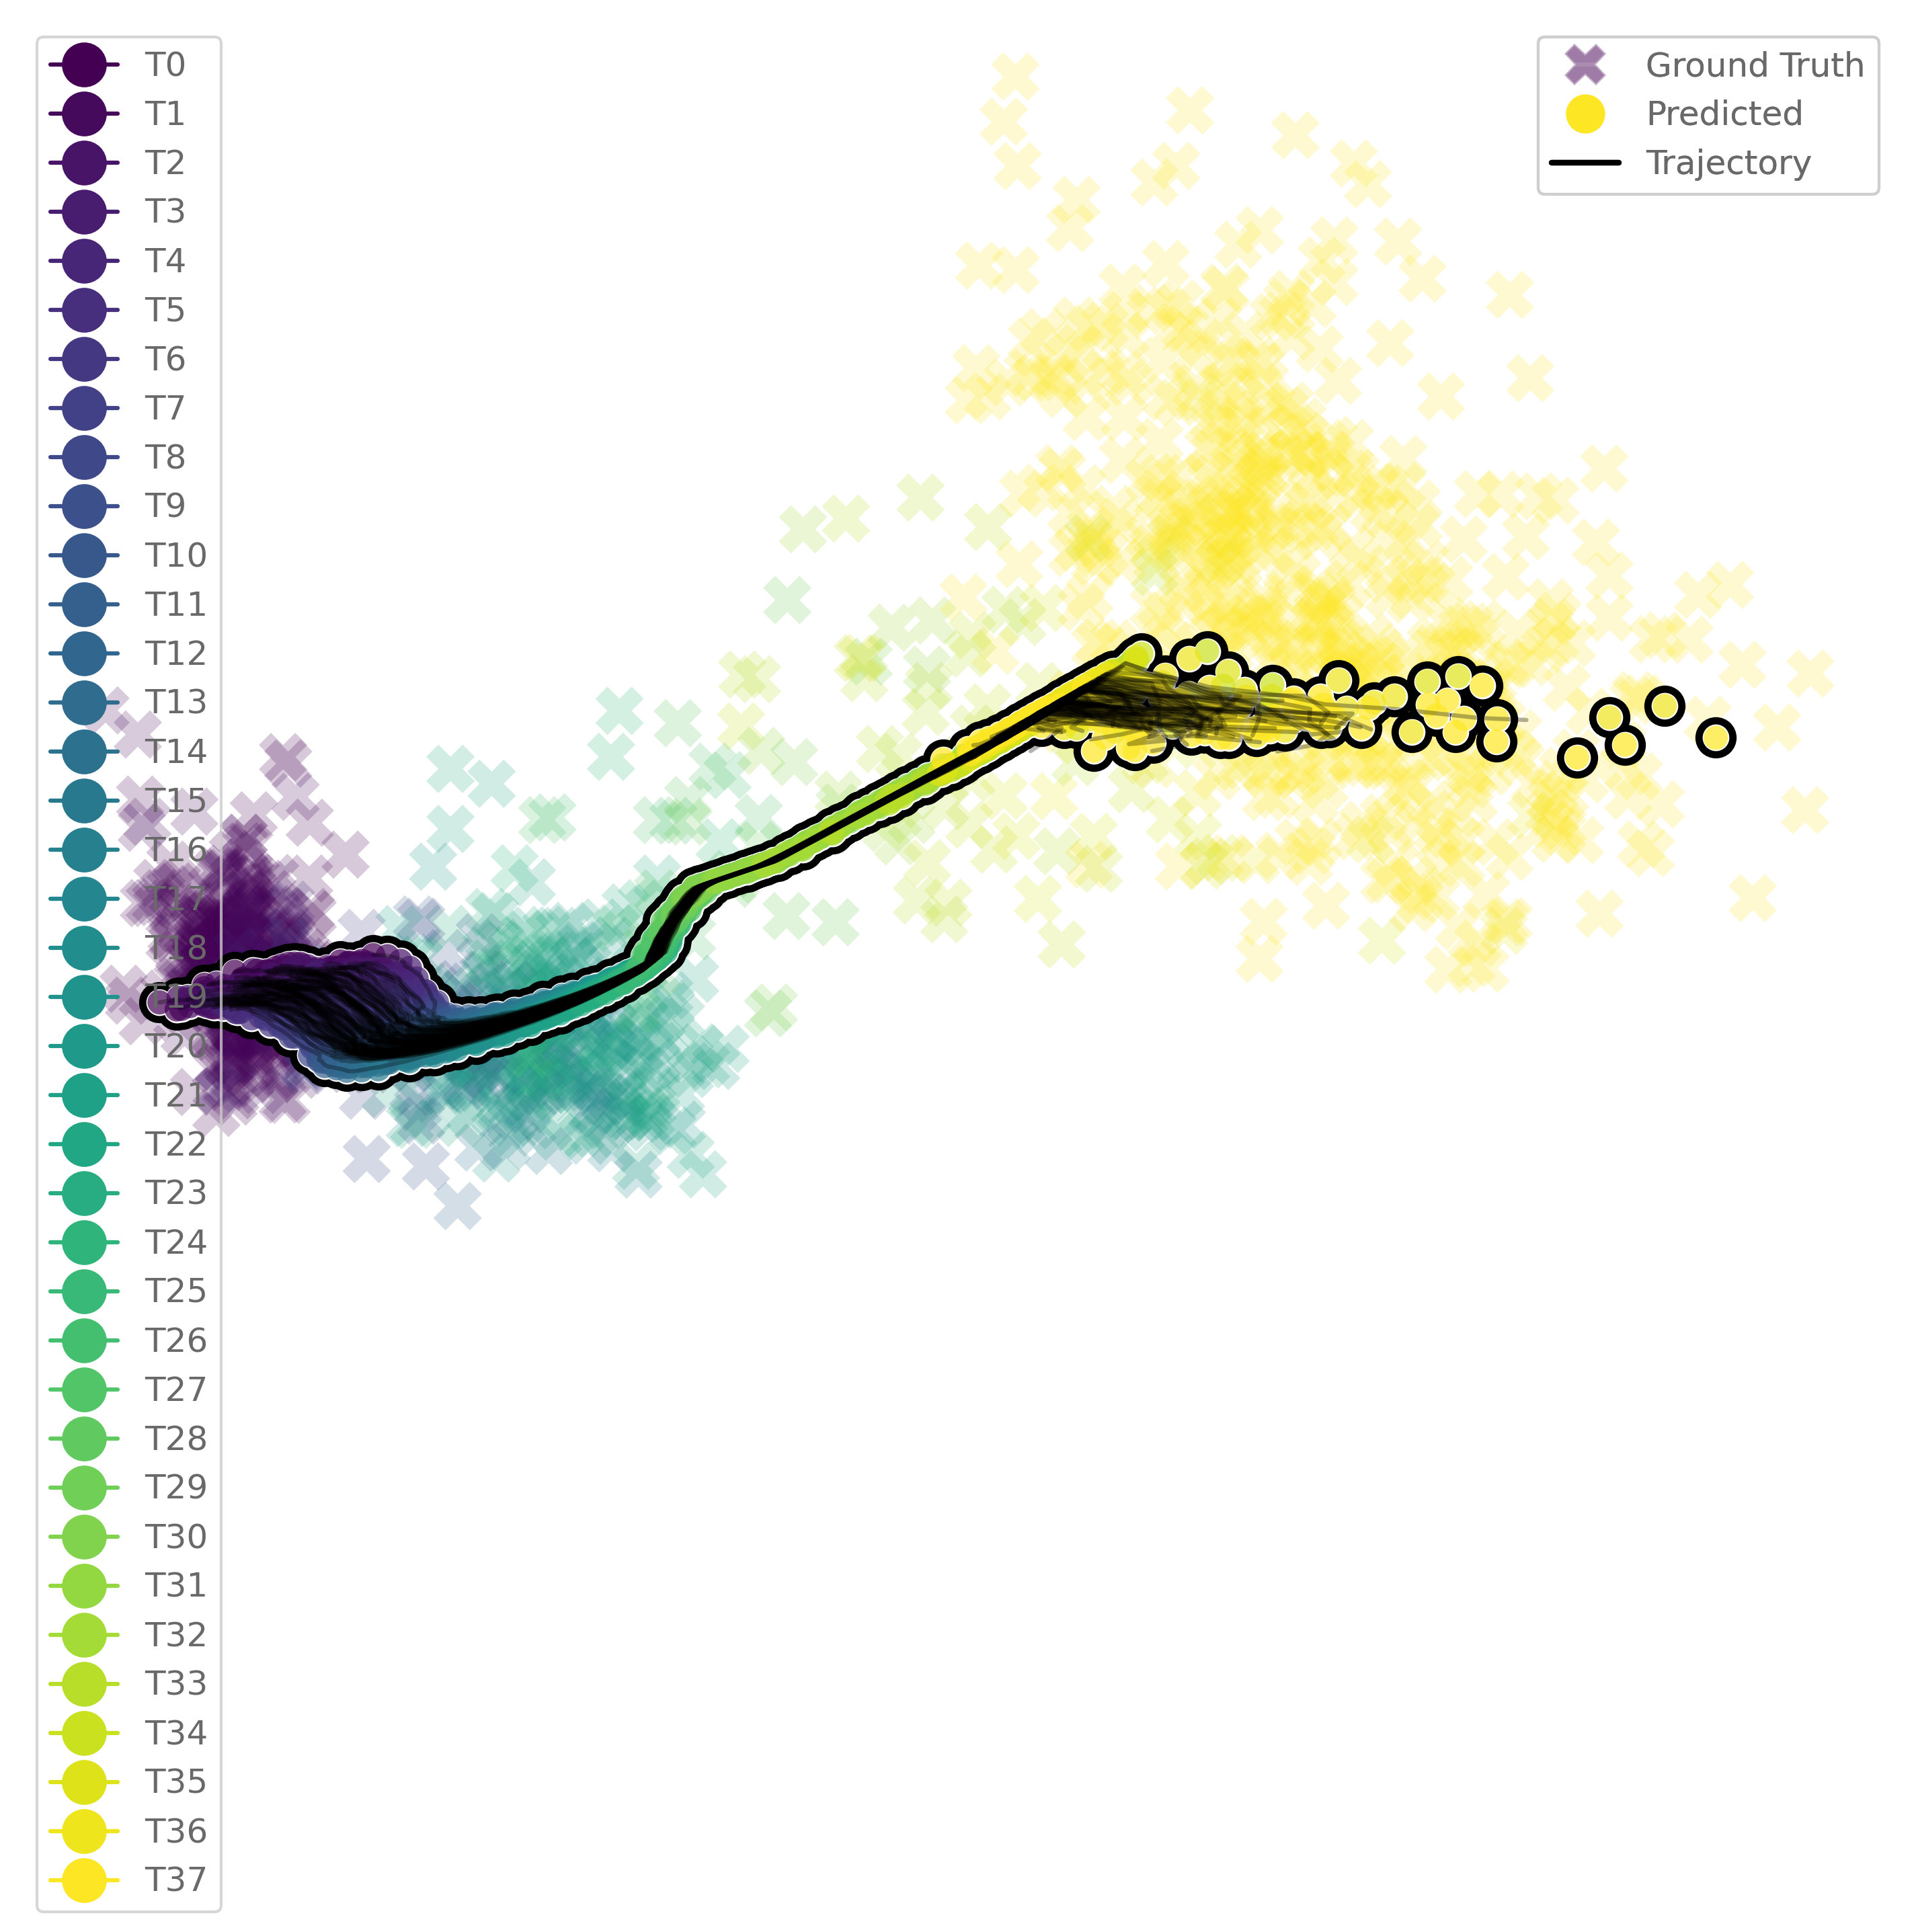

In [73]:
plot_comparision(
    df, generated, trajectories,
    palette = 'viridis', df_time_key='samples',
    save=True, path=exp_dir, file='2d_comparision.png',
    x='gene_0', y='gene_1', z='gene_2', is_3d=False
)

In [76]:
from MIOFlow.utils import to_np, get_groups_from_df, get_cell_types_from_df, get_sample_n_from_df
from MIOFlow.eval import generate_tjnet_trajectories, get_cell_indexes
from MIOFlow.plots import plot_gene_trends

In [77]:
where = 'start'
start = 0

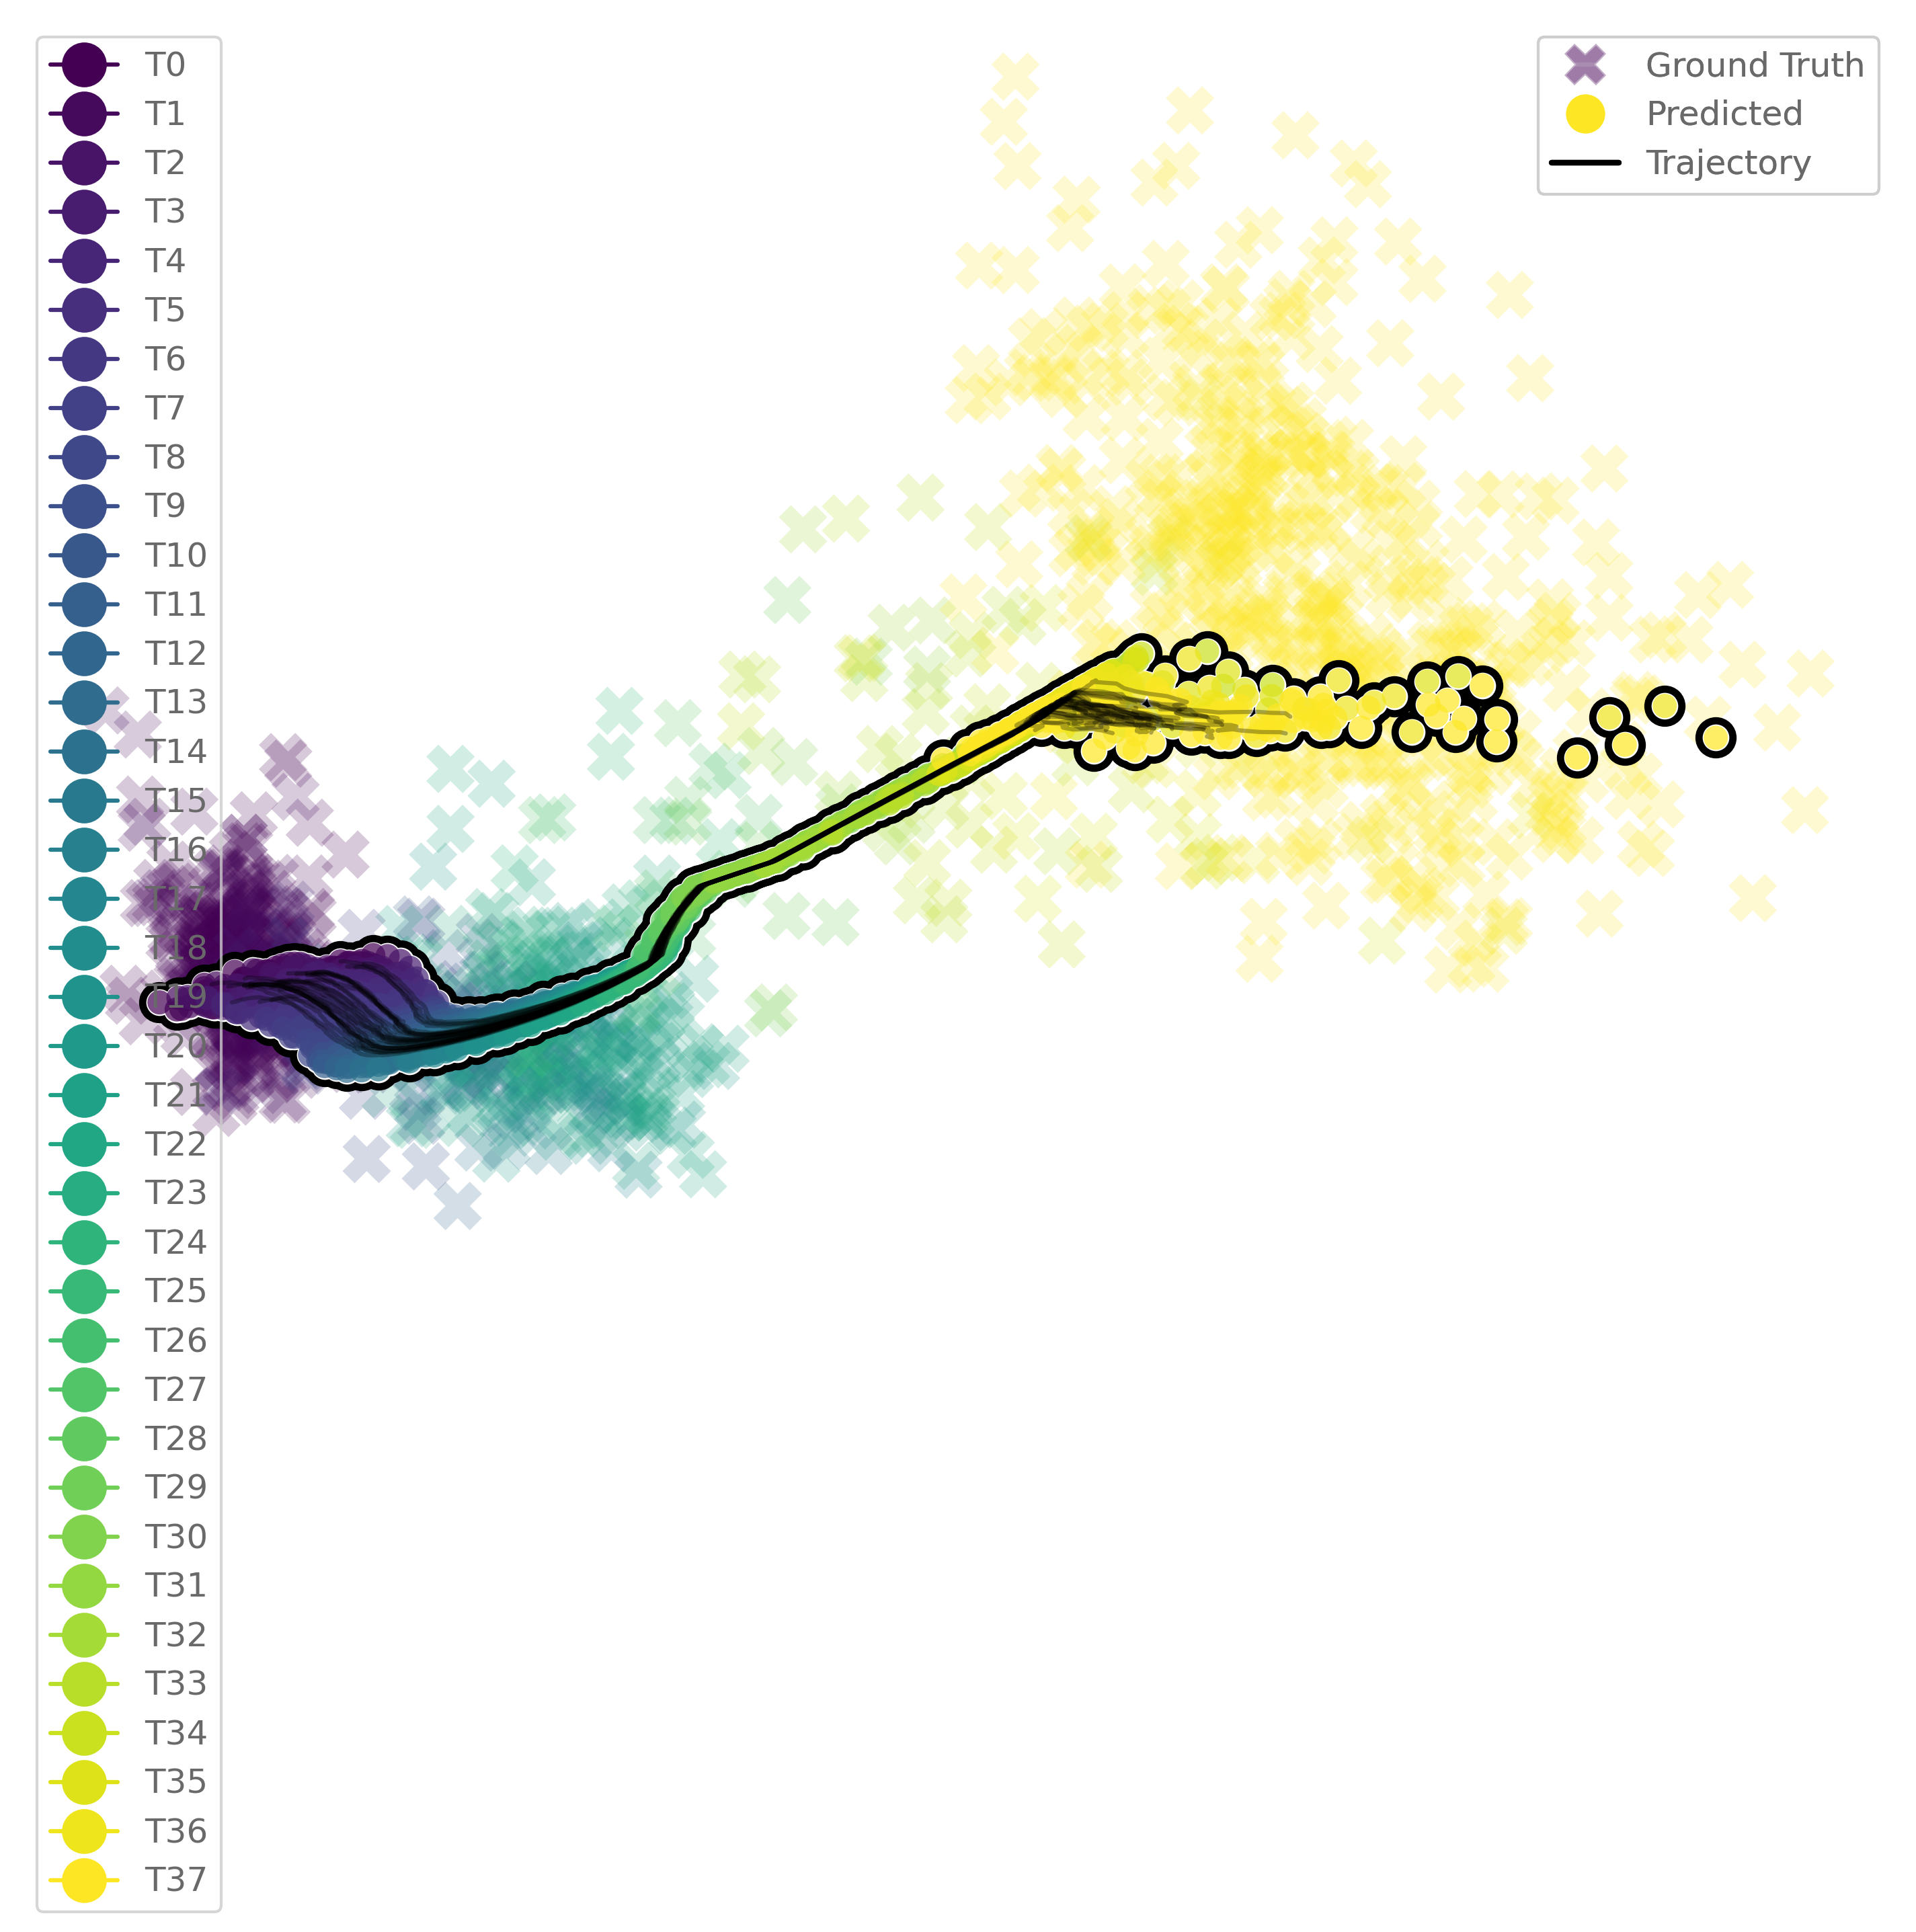

In [78]:
tjnet_trajectories = generate_tjnet_trajectories(
    model, df, use_cuda=use_cuda, autoencoder=autoencoder, recon=recon,
    where=where, start=start
)

plot_comparision(
    df, generated, 
    tjnet_trajectories[:, np.random.choice(tjnet_trajectories.shape[1], size=(30)), :],
    palette = 'viridis', df_time_key='samples',
    save=False, path=exp_dir, file='3d_comparision.png',
    x='gene_0', y='gene_1', z='gene_2', is_3d=False
)

In [79]:
genes = 'gene_0 gene_1 gene_2'.split()
where = 'start'
start = 0

In [86]:
phate_operator = phate.PHATE(n_components=2, n_jobs=-1, n_pca=50)

Y_phate = phate_operator.fit_transform(df.drop(columns=['samples']))

Calculating PHATE...
  Running PHATE on 1200 observations and 100 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculating KNN search...
    Calculated KNN search in 0.02 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.03 seconds.
  Calculating optimal t...
    Automatically selected t = 33
  Calculated optimal t in 0.21 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.10 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.64 seconds.
Calculated PHATE in 0.99 seconds.


In [87]:
pca_loadings = phate_operator.graph.data_nu
pca_components = phate_operator.graph.data_pca.components_

In [89]:
use_cell_types=False
tjnet_trajectories = generate_tjnet_trajectories(
    model, df, use_cuda=use_cuda, autoencoder=autoencoder, recon=recon,
    where=where, start=start, 
)

# pcs = phate_operator.graph.data_pca.components_
pcs = pca_components
genes, top_idxs, inverse, colors = get_cell_indexes(
    df, genes, tjnet_trajectories, pca_components, 
    where=where, start=start, samples=df.samples, use_cell_types=use_cell_types,
#     palette='tab10',
)
fig = plot_gene_trends(
    genes, top_idxs, inverse, colors, n_cols=4, samples=df.samples, where=where, start=start, 
    cell_types='AT1 AT2 Repair'.split(), use_cell_types=use_cell_types
)
fig

/home/solstice/anaconda3/envs/gode/lib/python3.10/site-packages/MIOFlow/utils.py:175: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  counts_n = df.reset_index(drop=drop_index)[df[samples_key] == groups[n]]


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).